In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import anndata as ad
import scanpy as sc
import scvi
import torch
from lightning.pytorch.loggers import CSVLogger
import session_info
import warnings
torch.set_float32_matmul_precision('high')
from pyprojroot.here import here

# Setting some parameters
warnings.filterwarnings("ignore")

scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

[rank: 0] Global seed set to 0
/scratch/groups/singlecell/software/anaconda3/envs/csf/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/scratch/groups/singlecell/software/anaconda3/envs/csf/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
[rank: 0] Global seed set to 0


Last run with scvi-tools version: 0.20.3


# Load data

In [2]:
# read adata object
adata = sc.read_h5ad('/scratch/devel/pnieto/projects/CSF/output/integration/B cells/B_cells_merged.h5ad')
adata

AnnData object with n_obs × n_vars = 9767 × 36601
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'project', 'sample', 'percent.mt', 'doublet_score', 'keep_cells', 'RNA_snn_res.0.1', 'RNA_snn_res.0.2', 'RNA_snn_res.0.3', 'RNA_snn_res.0.4', 'RNA_snn_res.0.5', 'RNA_snn_res.0.6', 'RNA_snn_res.0.7', 'RNA_snn_res.0.8', 'RNA_snn_res.0.9', 'RNA_snn_res.1', 'seurat_clusters', 'annot', 'barcode', 'CTgene', 'CTnt', 'CTaa', 'CTstrict', 'Frequency', 'cloneType', 'patient', 'annot_2', 'library', 'sub.cluster', 'percent.rb', 'OXPHOS_UCell', 'has_cnv_chr1', 'has_loss_chr1', 'has_dupli_chr1', 'proportion_cnv_chr1', 'proportion_loss_chr1', 'proportion_dupli_chr1', 'proportion_scaled_cnv_chr1', 'proportion_scaled_loss_chr1', 'proportion_scaled_dupli_chr1', 'has_cnv_chr2', 'has_loss_chr2', 'has_dupli_chr2', 'proportion_cnv_chr2', 'proportion_loss_chr2', 'proportion_dupli_chr2', 'proportion_scaled_cnv_chr2', 'proportion_scaled_loss_chr2', 'proportion_scaled_dupli_chr2', 'has_cnv_chr3', 'has_loss_chr3

# Preprocessing

In [3]:
sc.pp.highly_variable_genes(
    adata,
    flavor = "seurat_v3",
    n_top_genes = 3000,
    batch_key = "patient",
    subset = True,
    span = 1 # https://github.com/scverse/scanpy/issues/1504
)

# scVI Integration

In [4]:
# Hyper parameters
n_layers = 2
n_latent = 50
n_hidden = 256

In [5]:
scvi.model.SCVI.setup_anndata(
    adata, 
    batch_key = 'patient',
    categorical_covariate_keys = ['project']#,'disease']
)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [6]:
model_scVI = scvi.model.SCVI(
    adata, 
    n_layers = n_layers, 
    n_hidden = n_hidden, 
    n_latent = n_latent, 
    gene_likelihood = "nb"
)

In [7]:
model_scVI.view_anndata_setup()

Anndata setup with scvi-tools version 0.20.3.

Setup via `SCVI.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'patient',
│   'labels_key': None,
│   'size_factor_key': None,
│   'categorical_covariate_keys': ['project'],
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │  14   │
│         n_cells          │ 9767  │
│ n_extra_categorical_covs │   1   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │   1   │
│          n_vars          │ 3000  │
└──────────────────────────┴───────┘

                             Data Registry                             
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Registry Key      ┃            scvi-tools Location             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           X            │                  adata.X                   │
│         batch          │          adata.obs['_scvi_batch']          │
│ extra_categorical_covs │ adata.obsm['_scvi_extra_categorical_covs'] │
│         labels         │         adata.obs['_scvi_labels']          │
└────────────────────────┴────────────────────────────────────────────┘

                   batch State Registry                    
┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location    ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['patient'] │    P01     │          0          │
│                      │    P02     │          1          │
│                      │    P03     │          2          │
│                      │    P04     │          3          │
│                      │    P05     │          4          │
│                      │    P06     │          5          │
│                      │    P07     │          6          │
│                      │    P09     │          7          │
│                      │    P10     │          8          │
│                      │    P11     │          9          │
│                      │    P13     │         10          │
│                      │    P14     │         11          │
│                      │    P15     │         12          │
│                      │    P16     │         13          │
└──────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

           extra_categorical_covs State Registry           
┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location    ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['project'] │   CSF_01   │          0          │
│                      │   CSF_02   │          1          │
│                      │   CSF_03   │          2          │
│                      │   CSF_04   │          3          │
│                      │   CSF_05   │          4          │
│                      │            │                     │
└──────────────────────┴────────────┴─────────────────────┘

In [8]:
csv_logger = CSVLogger(
    save_dir = '/scratch/devel/pnieto/projects/CSF/output/integration/B cells/scVI_training_log_{}latent_{}hidden'.format(n_latent, n_hidden)
)
model_scVI.train(
    max_epochs = 400, 
    early_stopping = True, 
    early_stopping_monitor = 'reconstruction_loss_validation', 
    early_stopping_patience = 5,
    logger = csv_logger,
    log_every_n_steps = 10000
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 40/400:  10%|██                   | 40/400 [04:54<44:08,  7.36s/it, loss=885, v_num=1]
Monitored metric reconstruction_loss_validation did not improve in the last 5 records. Best score: 898.122. Signaling Trainer to stop.


In [9]:
print(model_scVI)

SCVI Model with the following params: 
n_hidden: 256, n_latent: 50, n_layers: 2, dropout_rate: 0.1, dispersion: gene, gene_likelihood: nb, 
latent_distribution: normal
Training status: Trained
Model's adata is minified?: False

In [10]:
adata.obsm['X_scVI'] = model_scVI.get_latent_representation()

In [24]:
adata.write(here("output/integration/B cells/B_cells_scVI_integrated_{}_latent.h5ad".format(n_latent)), compression="gzip")
model_scVI.save(here("output/integration/B cells/B_cells_scVI_integrated_{}_latent/".format(n_latent)))

ValueError: /scratch/devel/pnieto/projects/CSF/output/integration/B cells/B_cells_scVI_integrated_50_latent already exists. Please provide another directory for saving.

# Plots

In [26]:
log_path = here('output/integration/B cells/scVI_training_log_50latent_256hidden/lightning_logs/version_1/metrics.csv')
metricDF = pd.read_csv(log_path)

In [27]:
metricDF

,validation_loss,elbo_validation,reconstruction_loss_validation,kl_local_validation,kl_global_validation,epoch,step,train_loss_epoch,elbo_train,reconstruction_loss_train,kl_local_train,kl_global_train
0,1589.221802,1604.128052,1589.221802,14.906193,0.0,0,68,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,0,68,1376.905640,1401.685669,1376.905640,24.780062,0.0
2,1223.115967,1250.712769,1223.046875,27.665909,0.0,1,137,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,1,137,1043.021362,1095.074097,1042.890991,52.183109,0.0
4,1055.729858,1091.886597,1055.548218,36.338425,0.0,2,206,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
75,NaN,NaN,NaN,NaN,NaN,37,2621,887.693298,945.510803,881.800171,63.710655,0.0
76,911.789429,959.978943,906.730957,53.247967,0.0,38,2690,NaN,NaN,NaN,NaN,NaN
77,NaN,NaN,NaN,NaN,NaN,38,2690,887.453796,944.483643,881.467224,63.016422,0.0
78,917.414307,964.710938,912.304810,52.406158,0.0,39,2759,NaN,NaN,NaN,NaN,NaN


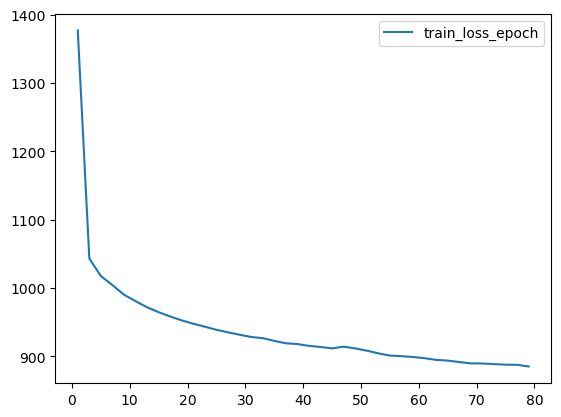

In [38]:
metricDF.train_loss_epoch.dropna().plot()
plt.legend()

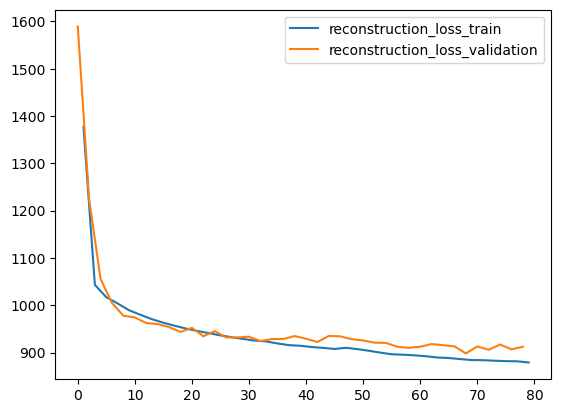

In [34]:
metricDF.reconstruction_loss_train.dropna().plot()
metricDF.reconstruction_loss_validation.dropna().plot()
plt.legend()

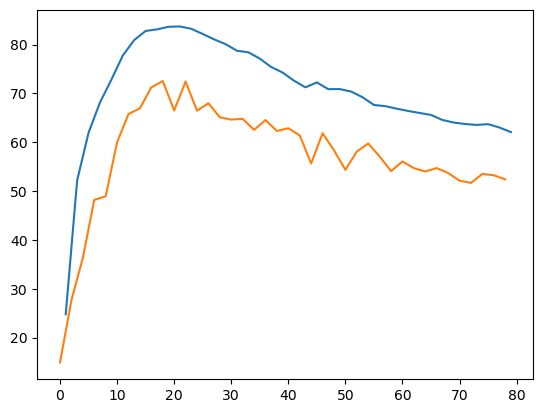

In [36]:
plt.plot(metricDF.kl_local_train.dropna())
plt.plot(metricDF.kl_local_validation.dropna())

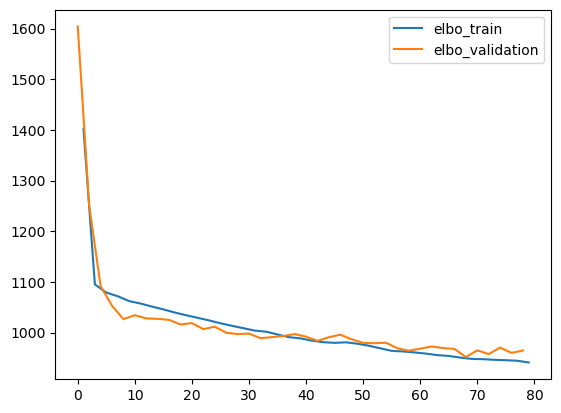

In [37]:
metricDF.elbo_train.dropna().plot()
metricDF.elbo_validation.dropna().plot()
plt.legend()